# Estimate a probability with Monte-Carlo on axial stressed beam: a quick start guide to reliability

The goal of this example is to show a simple practical example of probability estimation in a reliability study with the `ProbabilitySimulationAlgorithm` class. The `ThresholdEvent` is used to define the event. We use the Monte-Carlo method thanks to the `MonteCarloExperiment` class to estimate this probability and its confidence interval.

## Introduction

We consider a simple beam stressed by a traction load F at both sides.

<img src="axial-stressed-beam.png" width="250">

The geometry is supposed to be deterministic; the diameter D is equal to:

$$
D=0.02 \textrm{ (m)}.
$$

By definition, the yield stress is the load divided by the surface. Since the surface is $\pi D^2/4$, the stress is:

$$
S = \frac{F}{\pi D^2/4}.
$$

Failure occurs when the beam plastifies, i.e. when the axial stress gets larger than the yield stress:

$$
R - \frac{F}{\pi D^2/4} \leq 0
$$

where $R$ is the strength.
 
Therefore, the limit state function $G$ is: 

$$
G(R,F) = R - \frac{F}{\pi D^2/4},
$$

for any $R,F\in\mathbb{R}$.

The value of the parameter $D$ is such that:

$$
D^2/4 = 10^{-4},
$$

which leads to the equation:

$$
G(R,F) = R - \frac{F}{10^{-4} \pi}.
$$

We consider the following distribution functions.

| Variable | Distribution |
|--|--|
| R | LogNormal($\mu_R=3\times 10^6$, $\sigma_R=3\times 10^5$) [Pa] |
| F | Normal($\mu_F=750$, $\sigma_F=50$) [N] |

where $\mu_R=E(R)$ and $\sigma_R^2=V(R)$ are the mean and the variance of $R$.

The failure probability is: 

$$
P_f = \text{Prob}(G(R,F) \leq 0).
$$

The exact $P_f$ is 

$$
P_f = 0.02920.
$$

## Definition of the model

In [1]:
import openturns as ot
import numpy as np

The dimension of the problem.

In [2]:
dim = 2

We define the limit state function as a symbolic function. 

In [3]:
limitStateFunction = ot.SymbolicFunction(['R', 'F'], ['R-F/(1.e-4 * pi_)'])

Before using the function within an algorithm, we check that the limit state function is correctly evaluated.

In [4]:
x = [3.e6, 750.]
print('x=', x)
print('G(x)=', limitStateFunction(x))

x= [3000000.0, 750.0]
G(x)= [612676]


## Probabilistic model

We then create a first marginal, a univariate `LogNormal` distribution, parameterized by its mean and standard deviation.

In [5]:
R = ot.LogNormalMuSigma(3.e6, 3.e5, 0.0).getDistribution()
R.setName('Yield strength')
R.setDescription('R')

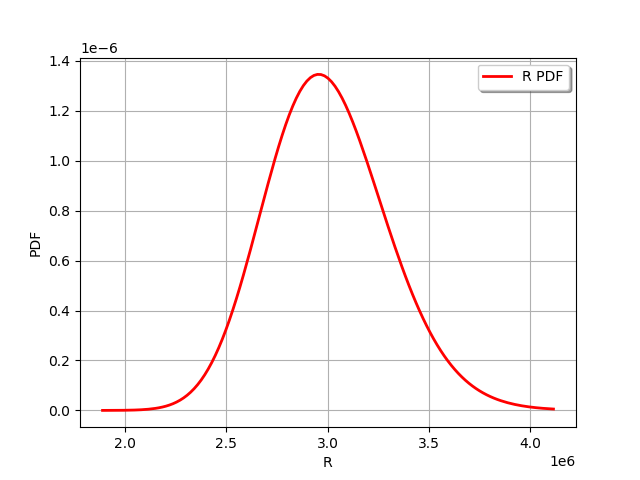

In [6]:
R.drawPDF()

Our second marginal is a `Normal` univariate distribution.

In [7]:
F = ot.Normal(750., 50.)
F.setName('Traction_load')
F.setDescription('F')

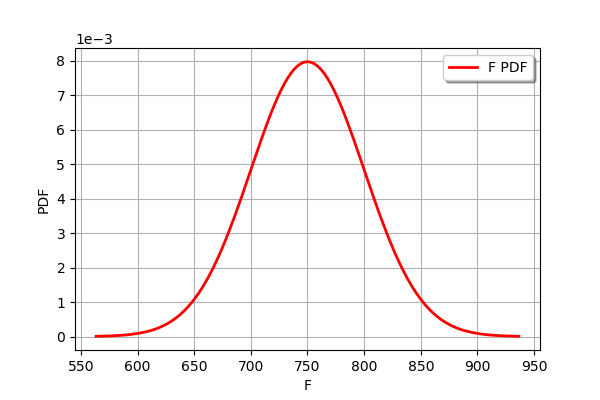

In [8]:
F.drawPDF()

In order to create the input distribution, we use the `ComposedDistribution` class which associates the distribution marginals and a copula. If no copula is supplied to the constructor, it selects the independent copula as default:

In [9]:
myDistribution = ot.ComposedDistribution([R, F])
myDistribution.setName('myDist')

We create a `RandomVector` from the `Distribution`, which will then be fed to the limit state function.

In [10]:
inputRandomVector = ot.RandomVector(myDistribution)

Finally we create a `CompositeRandomVector` by associating the limit state function with the input random vector.

In [11]:
outputRandomVector = ot.CompositeRandomVector(limitStateFunction, inputRandomVector)

## Exact computation

The simplest method is to perform an exact computation based on the arithmetic of distributions.

In [12]:
D = 0.02

In [13]:
G = R-F/(D**2/4 * np.pi)

In [14]:
G.computeCDF(0.)

0.02919819462483051

This is the exact result from the description of this example.

## Distribution of the output

Plot the distribution of the output.

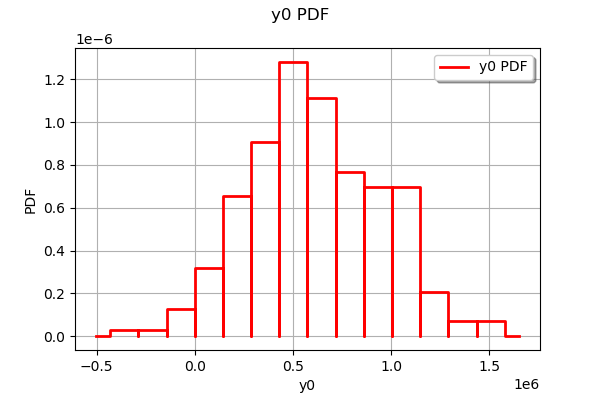

In [15]:
sampleSize = 500
sampleG = outputRandomVector.getSample(sampleSize)
ot.HistogramFactory().build(sampleG).drawPDF()

## Estimate the probability with Monte-Carlo

We first create a `ThresholdEvent` based on the output `RandomVector`, the operator and the threshold.

In [16]:
myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 0.0)

The `ProbabilitySimulationAlgorithm` is the main tool to estimate a probability. It is based on a specific design of experiments: in this example, we use the simplest of all, the `MonteCarloExperiment`. 

In [17]:
maximumCoV = 0.05 # Coefficient of variation
maximumNumberOfBlocks = 100000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(maximumNumberOfBlocks)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(maximumCoV)

In order to gather statistics about the algorithm, we get the initial number of function calls (this is not mandatory, but will prove to be convenient later in the study).

In [18]:
initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()

Now comes the costly part: the `run` method performs the required simulations. The algorithm stops when the coefficient of variation of the probability estimate becomes lower than 0.5.

In [19]:
algoMC.run()

We can then get the results of the algorithm. 

In [20]:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
numberOfFunctionEvaluations = limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
print('Number of calls to the limit state =', numberOfFunctionEvaluations)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())

Number of calls to the limit state = 12823
Pf =  0.030258129922794978
CV = 0.04999334672427731


The `drawProbabilityConvergence` method plots the probability estimate depending on the number of function evaluations. The order of convergence is $O \left( 1/N^2 \right)$ with $N$ being the number of function evaluations. This is why we use a logarithmic scale for the X axis of the graphics.

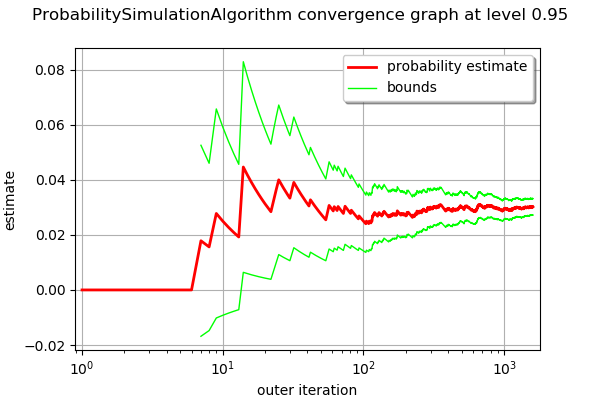

In [21]:
graph = algoMC.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
graph

We see that the 95% confidence interval becomes smaller and smaller and stabilizes at the end of the simulation.

In order to compute the confidence interval, we use the `getConfidenceLength` method, which returns the length of the interval. In order to compute the bounds of the interval, we divide this length by 2.

In [22]:
alpha = 0.05

In [23]:
pflen = result.getConfidenceLength(1-alpha)
print("%.2f%% confidence interval = [%f,%f]" % ((1-alpha)*100,probability-pflen/2,probability+pflen/2))

95.00% confidence interval = [0.027293,0.033223]


This interval is consistent with the exact probability $P_f=0.02920$.

## Appendix: derivation of the failure probability

The failure probability is: 

$$
P_f 
= \text{Prob}(R-S \leq 0)
= \int_{r-s \leq 0} f_{R, S}(r, s)drds
$$

where $f_{R, S}$ is the probability distribution function of the random vector $(R,S)$.
If R and S are independent, then: 

$$
f_{R, S}(r, s) = f_R(r) f_S(s)
$$

for any $r,s\in\mathbb{R}$, 
where $f_S$ is the probability distribution function of the random variable $S$ and $f_R$ is the probability distribution function of the random variable $R$.
Therefore,

$$
P_f 
= \int_{r-s \leq 0} f_R(r) f_S(s) drds.
$$

This implies:
$$
P_f 
= \int_{-\infty}^{+\infty} \left(\int_{r \leq s} f_R(r) dr \right) f_S(s) ds.
$$

Therefore,

$$
P_f 
= \int_{-\infty}^{+\infty}f_S(s)F_R(s)ds
$$

where $F_R$ is the cumulative distribution function of the random variable $R$.